# Dreamclinic Client Churn

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import datetime as dt

from sklearn.linear_model import LogisticRegression

In [191]:
pep8 = "0987654321" * 8

In [192]:
pep8

'09876543210987654321098765432109876543210987654321098765432109876543210987654321'

In [193]:
client_df = pd.read_excel("~/dales_work/clinic_services_8-1-2016_to_8-3-2019.xlsx")


In [194]:
client_df.drop('Name_Full', axis=1, inplace=True)

In [197]:
client_df.head()

,TransactionDate,clientID,Therapist,Address_City,Address_State,Address_Zip,Invoice_Category,Service_Category,HrsWorked
0,2016-08-02,40156.0,Michael Jacobus,Seattle,Wa,98109,Clinic_Ins,NaN,1.0
1,2016-08-02,60005.0,Lauren Anderson,seattle,wa,98119,Clinic_CA,Massage,1.0
2,2016-08-02,43420.0,Stefanie Smith,Seattle,WA,98144,Clinic_Ins,NaN,1.0
3,2016-08-02,56100.0,Elizabeth Panelo,Seattle,Wa,98203,Clinic_Ins,NaN,1.0
4,2016-08-02,57367.0,Daniel Cook,Seattle,WA,98115,Clinic_Ins,NaN,1.0


In [198]:
# remove rows where HrsWorked = 0 because they are just used by the front desk 
# staff
client_df  = client_df[client_df['HrsWorked'] != 0]

# fill NaN values in 'Service_Category with 'Massage'
client_df['Service_Category'].fillna(value='Massage', inplace=True)

# remove white space from Therapist names
client_df['Therapist'] = client_df['Therapist'].str.strip()

# make all therapist names lowercase to avoid typos in data entry
client_df['Therapist'] = client_df['Therapist'].str.lower()

# find and replace nicknames with domain knowledge
client_df = client_df.replace('abby thomson', 'abigail thomson')

#Drop Address_City and Addres_State Columns from Dataframe
client_df.drop(['Address_City', 'Address_State'], axis=1, inplace=True)

In [199]:
# Drop rows without a clientID
client_df.dropna(subset=['clientID'], inplace=True)

In [ ]:
# Adds year and month columns to dataframe
# client_df['Year'] = client_df['TransactionDate'].map(lambda x: x.year)

# client_df['Month'] = client_df['TransactionDate'].map(lambda x: x.month)

In [ ]:
# creates a Dataframe that groups by year and month and counts unique clients
# counts_by_month_df = client_df.groupby(['Year', 'Month']).nunique()

In [ ]:
# Cleans the counts_by_month_df to only include data that is applicaple to it's EDA
# counts_by_month_df.rename(columns={"clientID" : "unique_client_count", 
#                                    "Therapist" : "therapists_employed", 
#                                    "Zipcode" :"zipcodes_reached"}, inplace=True)

In [ ]:
#Drop unnessesary columns
# counts_by_month_df.drop(["TransactionDate", "Invoice_Category", "HrsWorked", "Year", "Month"], axis=1, inplace=True)

In [ ]:
# counts_by_month_df.head()

In [200]:
months = client_df.TransactionDate.dt.to_period("M")

In [201]:
g = client_df.groupby(per)

In [202]:
client_count_df = g.nunique()  #

In [203]:
client_count_df.drop('TransactionDate', axis=1, inplace= True)

In [204]:
client_count_df.reset_index(inplace=True)

In [205]:
client_count_df["client_count"] = client_count_df['clientID']

In [184]:
client_count_df.drop('clientID', axis=1, inplace=True)

In [185]:
client_count_df['TransactionDate'] = client_count_df['TransactionDate'].astype('str')

In [186]:
client_count_df.rename(columns={"clientID" : "unique_client_count", 
                                   "Therapist" : "therapists_employed", 
                                   "Zipcode" :"zipcodes_reached"}, inplace=True)


In [ ]:
client_count_df.drop(["Invoice_Category", "HrsWorked", "Year", "Month"], axis=1, inplace=True)

In [188]:
client_count_df.drop(['Service_Category'],axis=1,  inplace=True)

In [189]:
client_count_df.head()

,TransactionDate,therapists_employed,Address_Zip,Invoice_Category,HrsWorked,client_count
0,2016-08,59,163,2,6,1651
1,2016-09,55,166,2,6,1670
2,2016-10,54,153,2,7,1670
3,2016-11,56,158,2,7,1604
4,2016-12,57,155,2,10,1664


# Graph of unique client counts per month from August, 2016

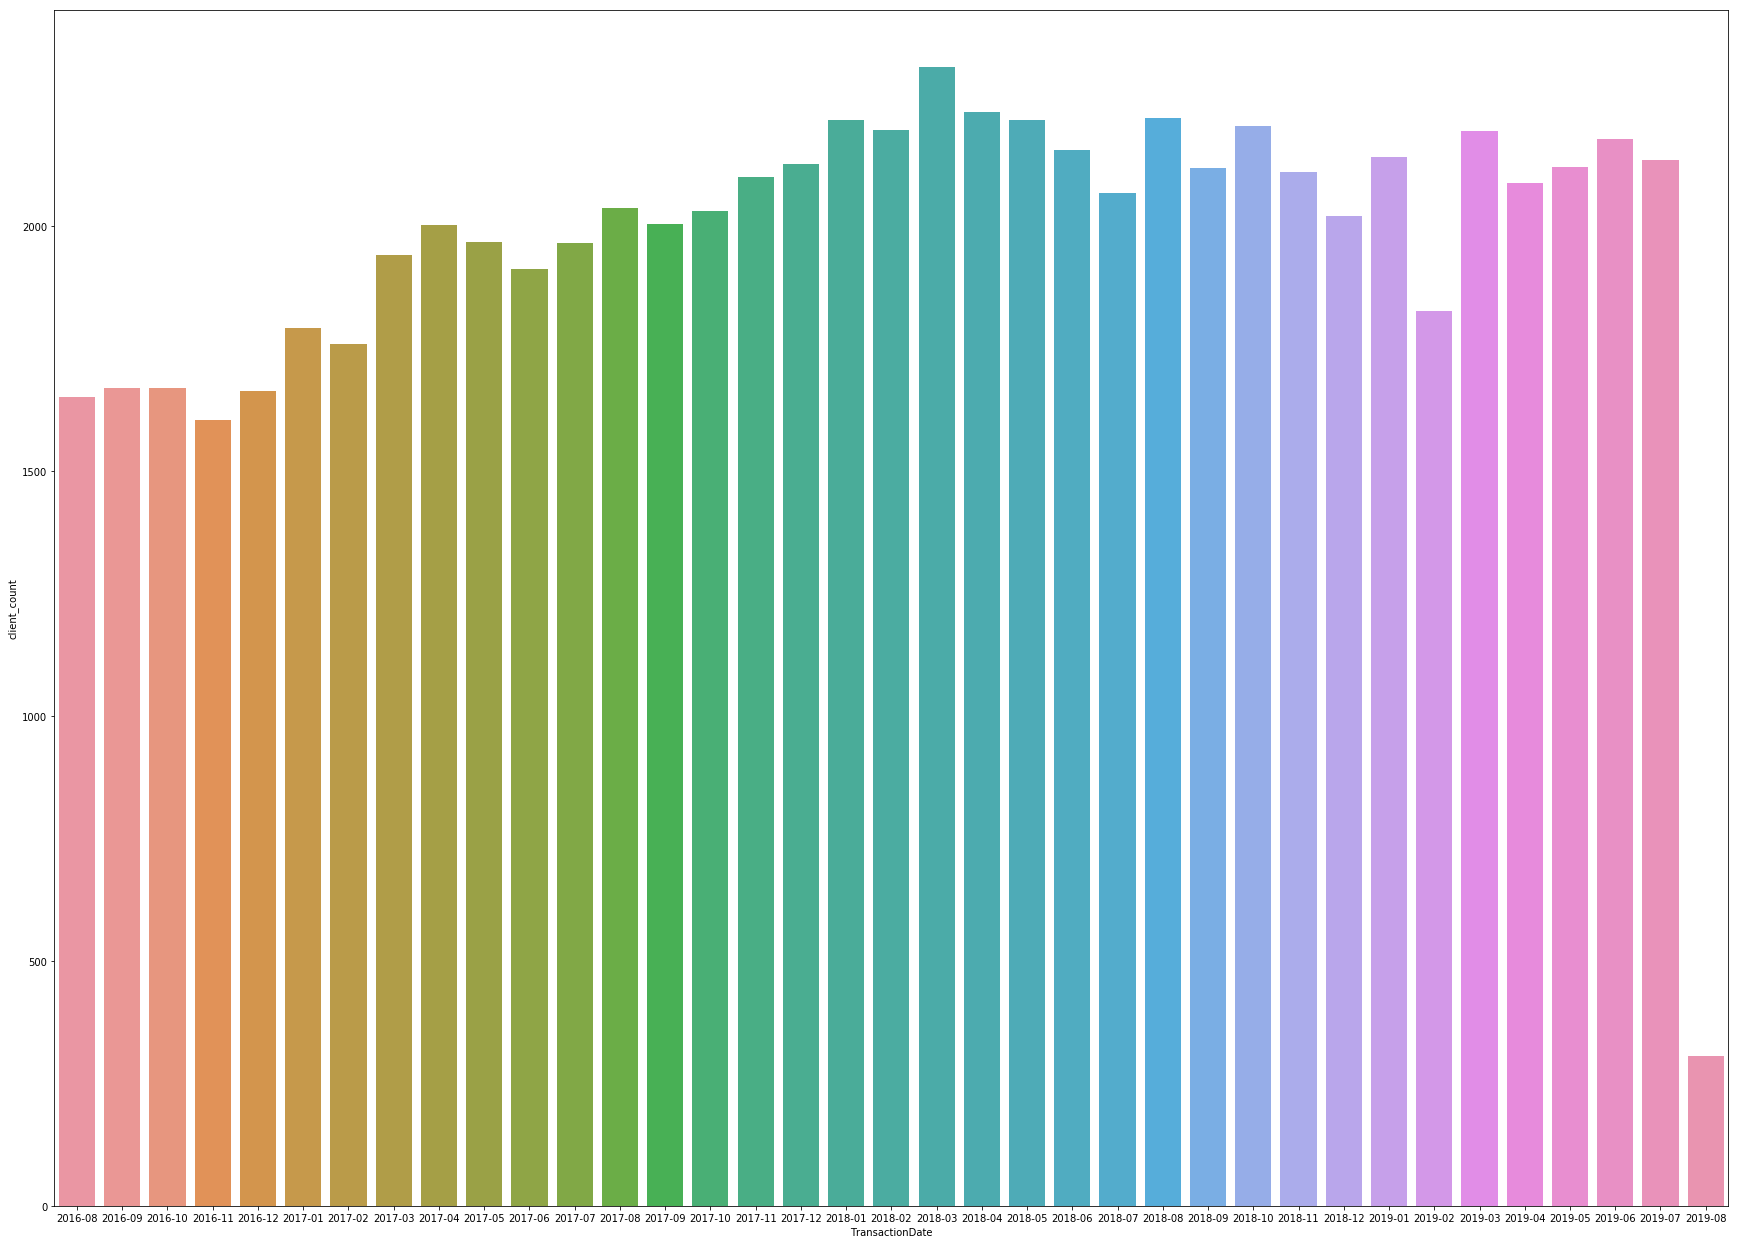

In [190]:
# the dip in Febuary of 2019 is explained by the 1 week snow closure of Seattle
x = client_count_df['TransactionDate']
y = client_count_df['client_count']


fig, ax = plt.subplots(figsize=(30,22))
sns.barplot(x= client_count_df['TransactionDate'], 
             y= client_count_df['client_count'],
             ax=ax);


In [ ]:
service_given_df = g.count()

In [ ]:
service_given_df.drop(['TransactionDate', 'Address_Zip'], axis=1, inplace=True)

In [ ]:
service_given_df.reset_index(inplace=True)

In [ ]:
service_given_df.rename(columns={'clientID': 'services_performed'}, inplace=True)

In [ ]:
services_given_df = service_given_df[["TransactionDate", "services_performed"]]


In [ ]:
services_given_df = services_given_df.rename(columns={"TransactionDate" : "month"})

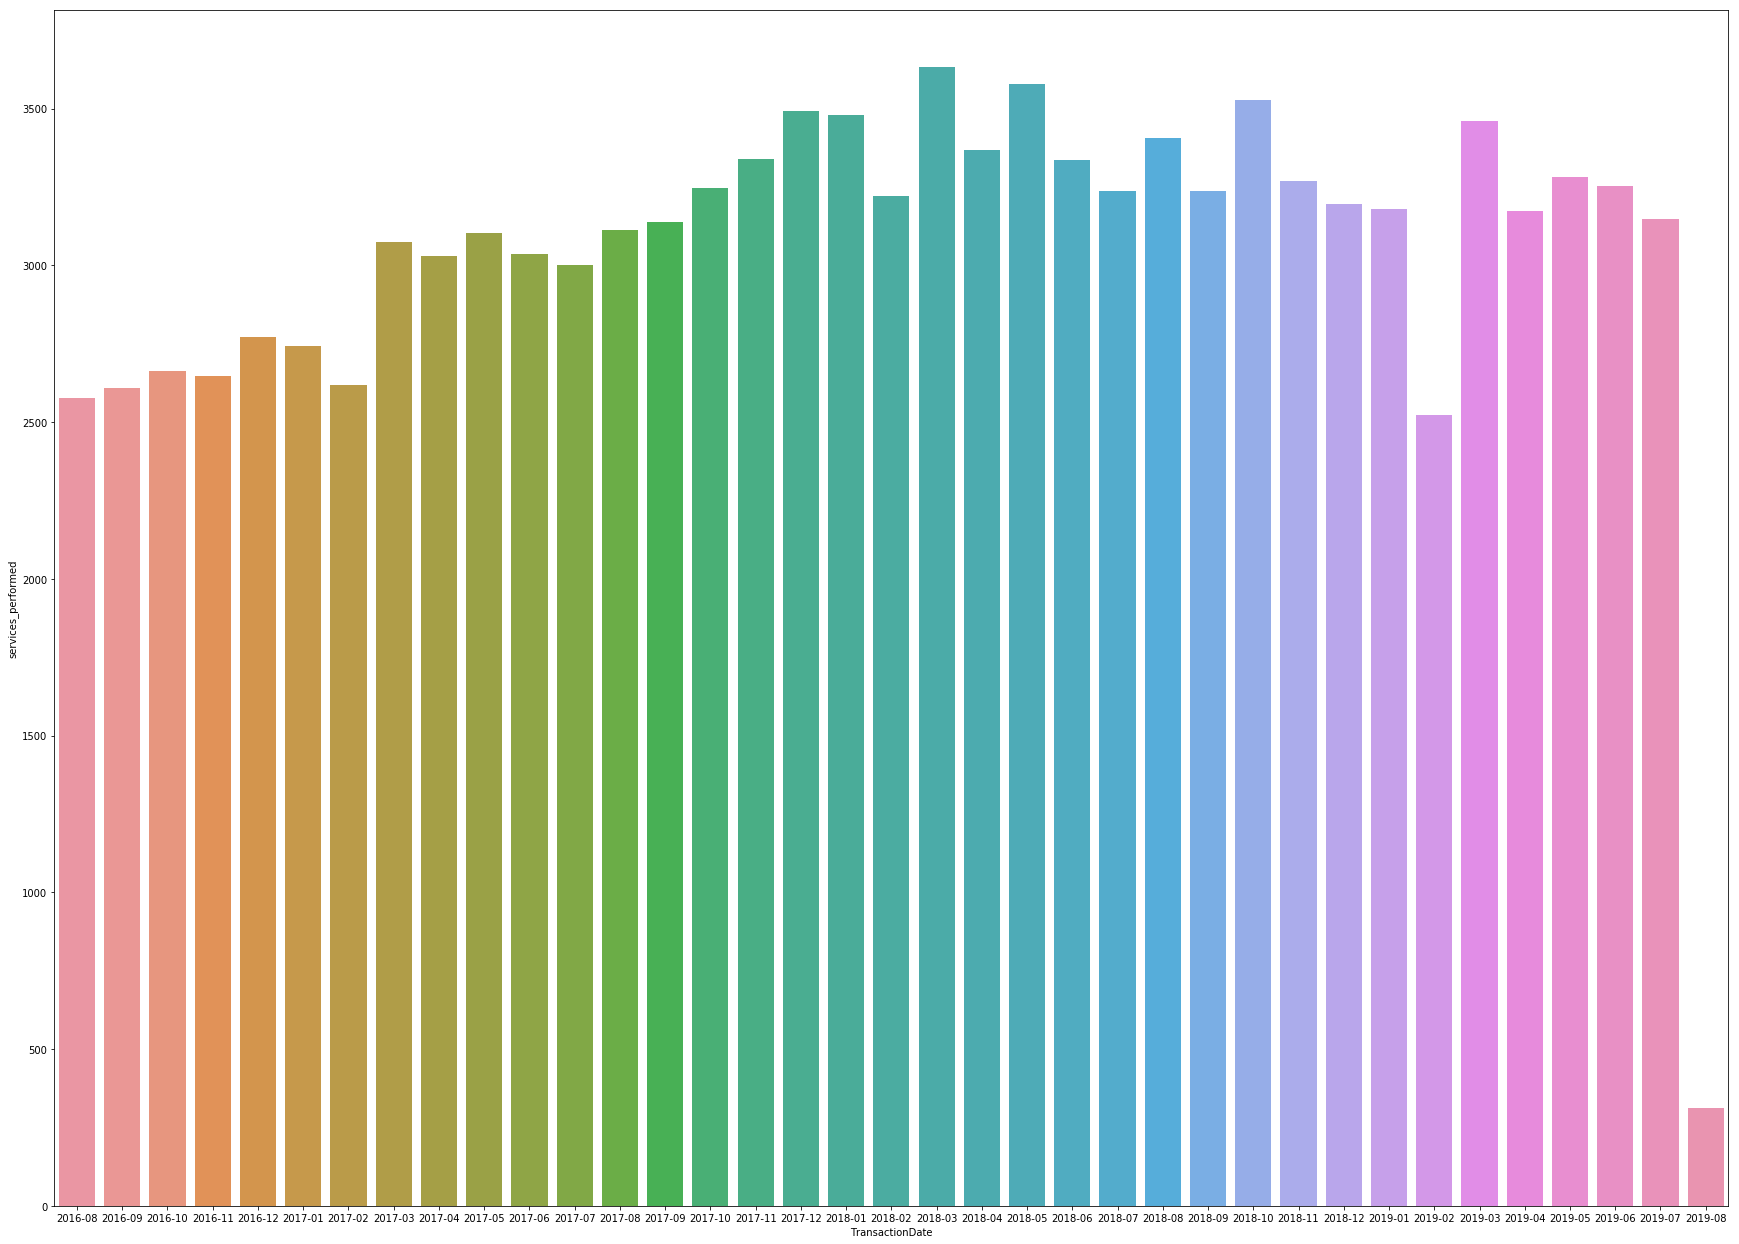

In [206]:
x = services_given_df['month']
y = services_given_df['services_performed']


fig, ax = plt.subplots(figsize=(30,22))
sns.barplot(x= service_given_df['TransactionDate'], 
             y= service_given_df['services_performed'],
             ax=ax);

# How many sessions did the average client from 2016-08 to 2019-08 receive?

In [ ]:
session_count = client_df.groupby('clientID').nunique()['TransactionDate']

The average number of sessions a client recieves is ~5.5.

The highest number of massages received is 175 by the CEO of the company


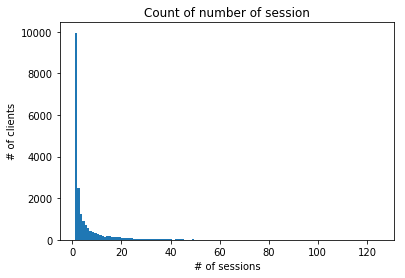

In [210]:
fig, ax = plt.subplots()
ax.hist(session_count, bins=125, range=(1,125))
plt.ylabel('# of clients')
plt.xlabel('# of sessions')
plt.title('Count of number of session');

In [ ]:
client_df.groupby('clientID').nunique()

## The average client get 5.5 sessions and sees 2.5 different therapists.
## People tend to get 1.25 hour sessions which is almost split between the 1h and 1.5h offerings we have.

In [90]:
client_df.groupby('clientID').nunique().mean()

TransactionDate     5.567647
clientID            1.000000
Therapist           2.577686
Address_Zip         0.920891
Invoice_Category    1.090646
Service_Category    1.075064
HrsWorked           1.242721
Year                1.514458
Month               2.887429
dtype: float64

# Mark Clients with Churned or Not Churned for further modeling

In [97]:
# last 2 months of unique client ids
client_df['clientID'].unique()

array([40156., 60005., 43420., ..., 83337., 83461., 28219.])

In [106]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113021 entries, 0 to 120496
Data columns (total 9 columns):
TransactionDate     113021 non-null datetime64[ns]
clientID            113021 non-null float64
Therapist           113020 non-null object
Address_Zip         110777 non-null object
Invoice_Category    113021 non-null object
Service_Category    113021 non-null object
HrsWorked           113021 non-null float64
Year                113021 non-null int64
Month               113021 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 8.6+ MB


In [146]:
start = client_df['TransactionDate'].searchsorted(dt.datetime(2019, 6, 1))
end = client_df['TransactionDate'].searchsorted(dt.datetime(2019, 8, 1))

In [147]:
not_churn_df = client_df.iloc[start:end]

In [112]:
not_churn_df['churn'] = False

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [160]:
client_ID_churn_false = pd.DataFrame(not_churn_df['clientID'].unique())

client_ID_churn_false['churn'] = False

client_ID_churn_false.columns

client_ID_churn_false.rename({0 : 'clientID'},axis=1, inplace=True)

client_ID_churn_false.shape

churn_df = client_df.merge(client_ID_churn_false, how='left', on='clientID')

churn_df['churn'].fillna(True, inplace=True)

churn_df.drop_duplicates(subset=['clientID', "TransactionDate_y"], 
                     keep = False, inplace = True) 



In [ ]:
from sklearn.linear_model import LogisticRegression

In [214]:
# Temporal test split
start = churn_df['TransactionDate'].searchsorted(dt.datetime(2018, 12, 1))
end = churn_df['TransactionDate'].searchsorted(dt.datetime(2019, 5, 31))
test_df = churn_df.iloc[start:end]


In [233]:
#Temporal train split
end = churn_df['TransactionDate'].searchsorted(dt.datetime(2018, 11, 30))
train_df = churn_df.iloc[:end]

In [ ]:
train_df['clientID'].unique()

weeds_df = train_df.groupby('clientID').nunique()

weeds_train_df = weeds_df[['TransactionDate', 'Therapist', 'Service_Category']]

In [243]:
weeds_train_df.head()

,TransactionDate,Therapist,Service_Category
clientID,,,
1001.0,140,106,3
1030.0,1,1,1
1065.0,1,1,1
1073.0,3,2,1
1075.0,2,2,1


In [242]:
test_df['clientID'].unique()

weeds_test_df = test_df.groupby('clientID').nunique()

weeds_test_df = weeds_test_df[['TransactionDate', 'Therapist', 'Service_Category']]

weeds_test_df.merge()

,TransactionDate,Therapist,Service_Category
clientID,,,
1001.0,16,14,1
1030.0,1,1,1
1073.0,2,2,1
1075.0,3,3,1
1338.0,1,1,1


In [251]:
churn_df_id_churn = churn_df[['clientID', 'churn']]

In [254]:
# churn or not df for all client IDS, useful for merging
churn_df_id_churn.drop_duplicates(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [258]:
weeds_test_df.shape

(6034, 3)

In [259]:
test_merge_df = weeds_test_df.merge(churn_df_id_churn, how='inner', right_on='clientID', left_index=True)

test_merge_df.reset_index(inplace=True)

test_merge_df.drop('index', axis=1, inplace=True)

In [276]:
test_merge_df.head()

,TransactionDate,Therapist,Service_Category,clientID,churn
0,16,14,1,1001.0,False
1,1,1,1,1030.0,True
2,2,2,1,1073.0,True
3,3,3,1,1075.0,False
4,1,1,1,1338.0,True


In [263]:
train_merge_df = weeds_train_df.merge(churn_df_id_churn, how='inner', right_on='clientID', left_index=True)

train_merge_df.reset_index(inplace=True)


train_merge_df.drop('index', axis=1, inplace=True)

train_target = train_merge_df['churn']

In [290]:
train_merge_df.head()

,TransactionDate,Therapist,Service_Category,clientID,churn
0,140,106,3,1001.0,False
1,1,1,1,1030.0,True
2,1,1,1,1065.0,True
3,3,2,1,1073.0,True
4,2,2,1,1075.0,False


In [278]:
X_train = train_merge_df[['TransactionDate', 'Therapist', 'Service_Category', 'clientID']]
y_train = train_merge_df['churn']
X_test =  test_merge_df[['TransactionDate', 'Therapist', 'Service_Category', 'clientID']]
y_test = test_merge_df['churn']

In [272]:
log_reg = LogisticRegression()

In [279]:
log_reg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [287]:
# first model is barely better then just guessing the mean

0.674842558833278

In [289]:
y_test.mean()

0.6710308253231687

In [297]:
from sklearn.metrics import roc_auc_score, roc_curve

In [293]:
roc_auc_score(y_test, log_reg.predict(X_test))

0.5084898905286811

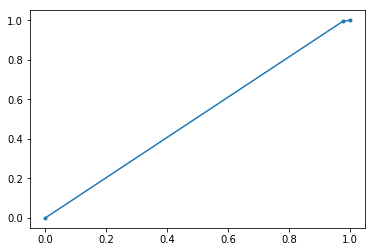

In [296]:
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict(X_test))
plt.plot(fpr, tpr, marker='.')
plt.show();